In [1]:
!pip install -q condacolab

import condacolab
condacolab.install()

# install ngspice packages, including executables & master package
!conda install -c conda-forge ngspice-exe  
!conda install -c conda-forge ngspice      
!conda install -c conda-forge ngspice-lib

!pip install PySpice

!pyspice-post-installation --check-install


RuntimeError: This module must ONLY run as part of a Colab notebook!

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
from PySpice.Spice.Netlist import Circuit
from scipy.fft import rfft, rfftfreq
from scipy import optimize
from scipy.integrate import trapezoid

In [5]:
#################
# 1. Параметры рабочей точки ВЧ разряда
#################
Vm = 100                                    # Амплитуда ВЧ источника [V]
f0 = 13.56e+6                               # Частота ВЧ источника [Гц]
#f0 = 81.36e6
#p0 = 3                                   # Давление газа [Па]
p0=0.66
T0 = 300                                    # Температура буферного газа [К]
ne = 1.25e+15                               # Начальное приближение плотности электронов [м^-3]
l_B = 5.7e-2                                # Толщина bulk плазмы [м]
#l_B = 10e-2                                # Толщина bulk плазмы [м]
Ae = 0.01                                   # Площадь нагруженного электрода [м^2]
Ag = 0.03                                   # Площадь заземленного электрода [м^2]

#################
# 2. Физические константы
#################
qe = 1.6e-19                                # Заряд электрона [Кл]
me = 9.11e-31                               # Масса электрона [кг]
Mi = 6.6335209e-26-9.1093837e-31            # Масса иона Ar [кг]
eps_0 = 8.85e-12                            # Диэлектрическая постоянная [Ф/м]
k_B = 1.380649e-23                          # Постоянная Больцмана [Дж/К]

#################
# 3. Вычисляемые величины №1
#################
ng = p0/(k_B*T0)                            # Концентрация буферного газа [м^-3]
Vp = Ae*l_B                                 # Объем плазменного столба
fE = Ae/(Ae + Ag)
fG = Ag/(Ae + Ag)
Tf=1/f0                                     # Период ВЧ поля [с]

#################
# 4. Настройки анализа Ngspice и алгоритма
#################
num_periods_sim=500                         # Количество периодов ВЧ поля, которое надо просчитать
sim_periods_div=100                         # Количество точек результата на период
tmax_sim = Tf*num_periods_sim               # Сколько времени просчитывать в Ngspice
tmin_sim = Tf*(num_periods_sim-5)           # От какого времени делать вывод
timestep_output = Tf/sim_periods_div        # Шаг, с которым будет вывод
eps_ne = 5e12                               # Критерий сходимости расчета ne

In [6]:
##############
# 5. Определение вспомогательнх функций
##############

def Kex_novec(Te):
    res = 5.02e-15*np.exp(-12.64/Te)   # 3p1 11.5 eV
    return(res)
Kex = np.vectorize(Kex_novec, otypes=[float])

def Kel_novec(Te):
    lnkel = -31.3879 + 1.6090*np.log(Te) + 0.0618*np.log(Te)**2 - 0.1171*np.log(Te)**3
    #print(f'lnkel = {lnkel}')
    res = np.exp(lnkel)
#    res = lnkel
    return(res)
Kel = np.vectorize(Kel_novec, otypes=[float])

def Kiz_novect(Te):
    res = 2.34e-14*Te**0.59*np.exp(-17.44/Te)   # Хорошо совпадает с [Schmidt]
#    res = 2.9e-14*Te**0.50*np.exp(-17.8/Te)
#    res = 7.93e-13*np.exp(-18.9/Te)      # Плохо совпадает с [Schmidt]
    return(res)
Kiz = np.vectorize(Kiz_novect, otypes=[float])

def u_Bohm_novect(Te):
    return np.sqrt(qe*Te/Mi)
u_Bohm = np.vectorize(u_Bohm_novect, otypes=[float])

def get_mean (a_T, a_V, a_N):
    return 1/(a_N*Tf) * trapezoid(x=a_T, y=a_V)

def extract_N_periods(array, start, periods_count, direction):
    if direction == 'fwd':
        return array[start*sim_periods_div:(start+periods_count)*sim_periods_div]
    elif direction == 'rev':
        return array[-(start+periods_count)*sim_periods_div:-start*sim_periods_div]
    
def getU (a_n1, a_n2, a_an):
    if a_n2 == '0':
        return np.array(a_an[a_n1])
    else:
        return np.array(a_an[a_n1])-np.array(a_an[a_n2])
    
def ang_normalize_novec(angle):
	return np.arctan2(np.sin(angle),np.cos(angle))
ang_normalize = np.vectorize(ang_normalize_novec, otypes=[float])

def get_spectra(a_Data, a_nHarm = 10, num_periods_for_spectra = 10):
    
    data_cut = extract_N_periods(a_Data, first_steady_period, num_periods_for_spectra, 'fwd')
    _spectra = rfft(data_cut)/(num_periods_for_spectra*sim_periods_div)
    _freqs = rfftfreq(data_cut.size, d=Tf/sim_periods_div)
    
    freqsMHz = _freqs/1e6

    full_abs = np.abs(_spectra)
    full_angle = np.angle(_spectra)
    
    idxHarm = (a_nHarm+1)*num_periods_for_spectra             # Индекс в массиве результатов fft, чтобы вырезать (немного больше) N гармоник
    reduced_spectra = _spectra[0:idxHarm]                   

    reduced_freqs = freqsMHz[0:idxHarm]                        
    reduced_abs = np.abs(reduced_spectra)[0:idxHarm]
    reduced_angle = np.angle(reduced_spectra)[0:idxHarm]

    
    idxrange = np.arange(start=num_periods_for_spectra,              
                         stop=(a_nHarm+1)*num_periods_for_spectra,
                         step=num_periods_for_spectra)
    
    waste_freqs = np.delete(reduced_freqs, idxrange)          # "Мусорные" гармоники, лежащие между кратными f0
    waste_abs = np.delete(reduced_abs, idxrange)
    waste_angle = np.delete(reduced_angle, idxrange)

    true_freqs = reduced_freqs[idxrange]                   # Гармоники с частотами, кратными f0
    true_abs = reduced_abs[idxrange]
    true_angle = reduced_angle[idxrange]
    
    return (_spectra, full_abs, full_angle, _freqs, freqsMHz, reduced_freqs, reduced_abs, reduced_angle, waste_freqs, waste_abs, waste_angle, true_freqs, true_abs, true_angle)

Te=4.748 [eV]


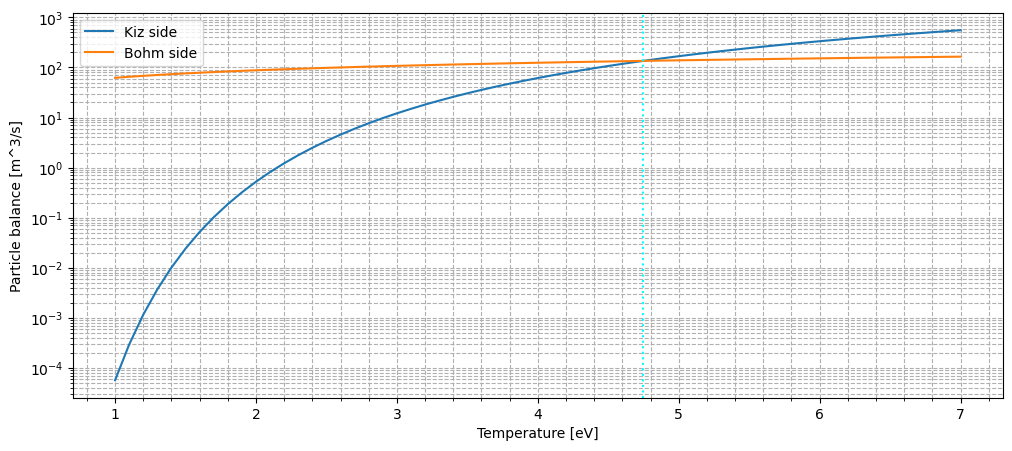

In [7]:
##############
# 6. Определение Te
##############

# Пытаемся найти Te как корень баланса частиц Vp*ng*Kiz(Te)-(Ae + Ag)*u_Bohm(Te) на отрезке [1-7] eV
def dfr(a_Te):
    return Vp*ng*Kiz_novect(a_Te)-(Ae + Ag)*u_Bohm_novect(a_Te)

sol = optimize.root_scalar(dfr, bracket=[1, 7], x0=3, x1=5, xtol=1e-3, method='secant')
Te = sol.root
print(f'Te={Te:.3f} [eV]')

# Строим график для ручной проверки

en_range = np.arange(1, 7.1, 0.1)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 1, 1)
minor_ticks = np.arange(0, 101, 4)
ax.set_xticks(minor_ticks, minor=True)
plt.plot(en_range, Vp*ng*Kiz(en_range), label='Kiz side')
plt.plot(en_range, (Ae + Ag)*u_Bohm(en_range), label='Bohm side')
plt.axvline(Te, color='cyan', linestyle=':')
plt.grid(which='minor', linestyle='--')
plt.grid(which='major', linestyle='--')
plt.minorticks_on()
plt.yscale('log')
plt.xlabel('Temperature [eV]')
plt.ylabel('Particle balance [m^3/s]')
plt.legend()
plt.show()

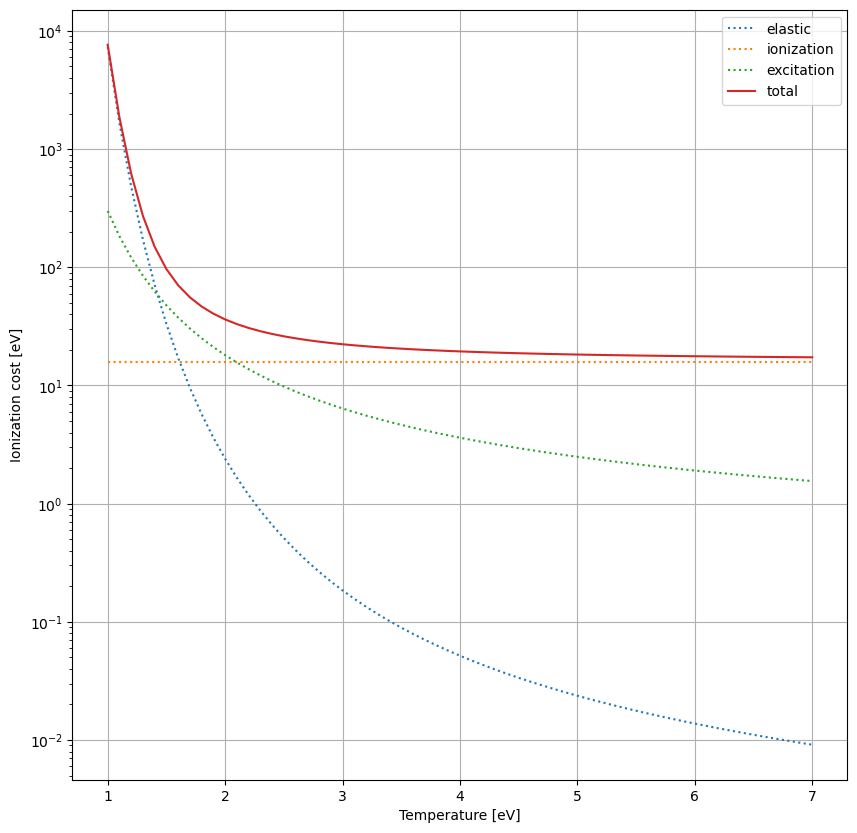

In [8]:
eps_ex = 11.5
eps_el = 3*me*Te/Mi
eps_iz = 15.76 # Энергия ионизации Ar [eV]
eps_e = 2*Te


def eps_c_novec(Te):
    return eps_iz + (Kel(Te)*eps_el + Kex(Te)*eps_ex)/Kiz(Te)
eps_c = np.vectorize(eps_c_novec, otypes=[float])

plt.figure(figsize=(10, 10))
plt.plot(en_range, (Kel(en_range)*eps_el)/Kiz(en_range), linestyle=':', label = 'elastic')
plt.plot(en_range, eps_iz*np.ones(en_range.size), linestyle=':', label = 'ionization')
plt.plot(en_range, (Kex(en_range)*eps_ex)/Kiz(en_range), linestyle=':', label = 'excitation')
plt.plot(en_range, eps_c(en_range), label = 'total')
plt.yscale('log')
plt.xlabel('Temperature [eV]')
plt.ylabel('Ionization cost [eV]')
plt.legend()
plt.grid()

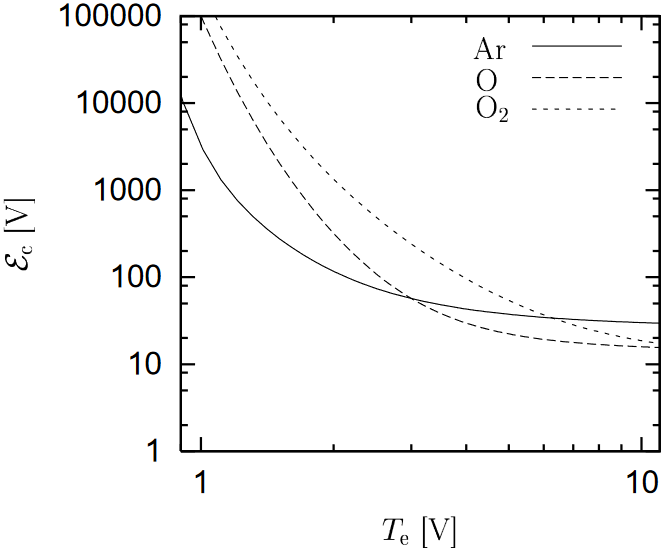

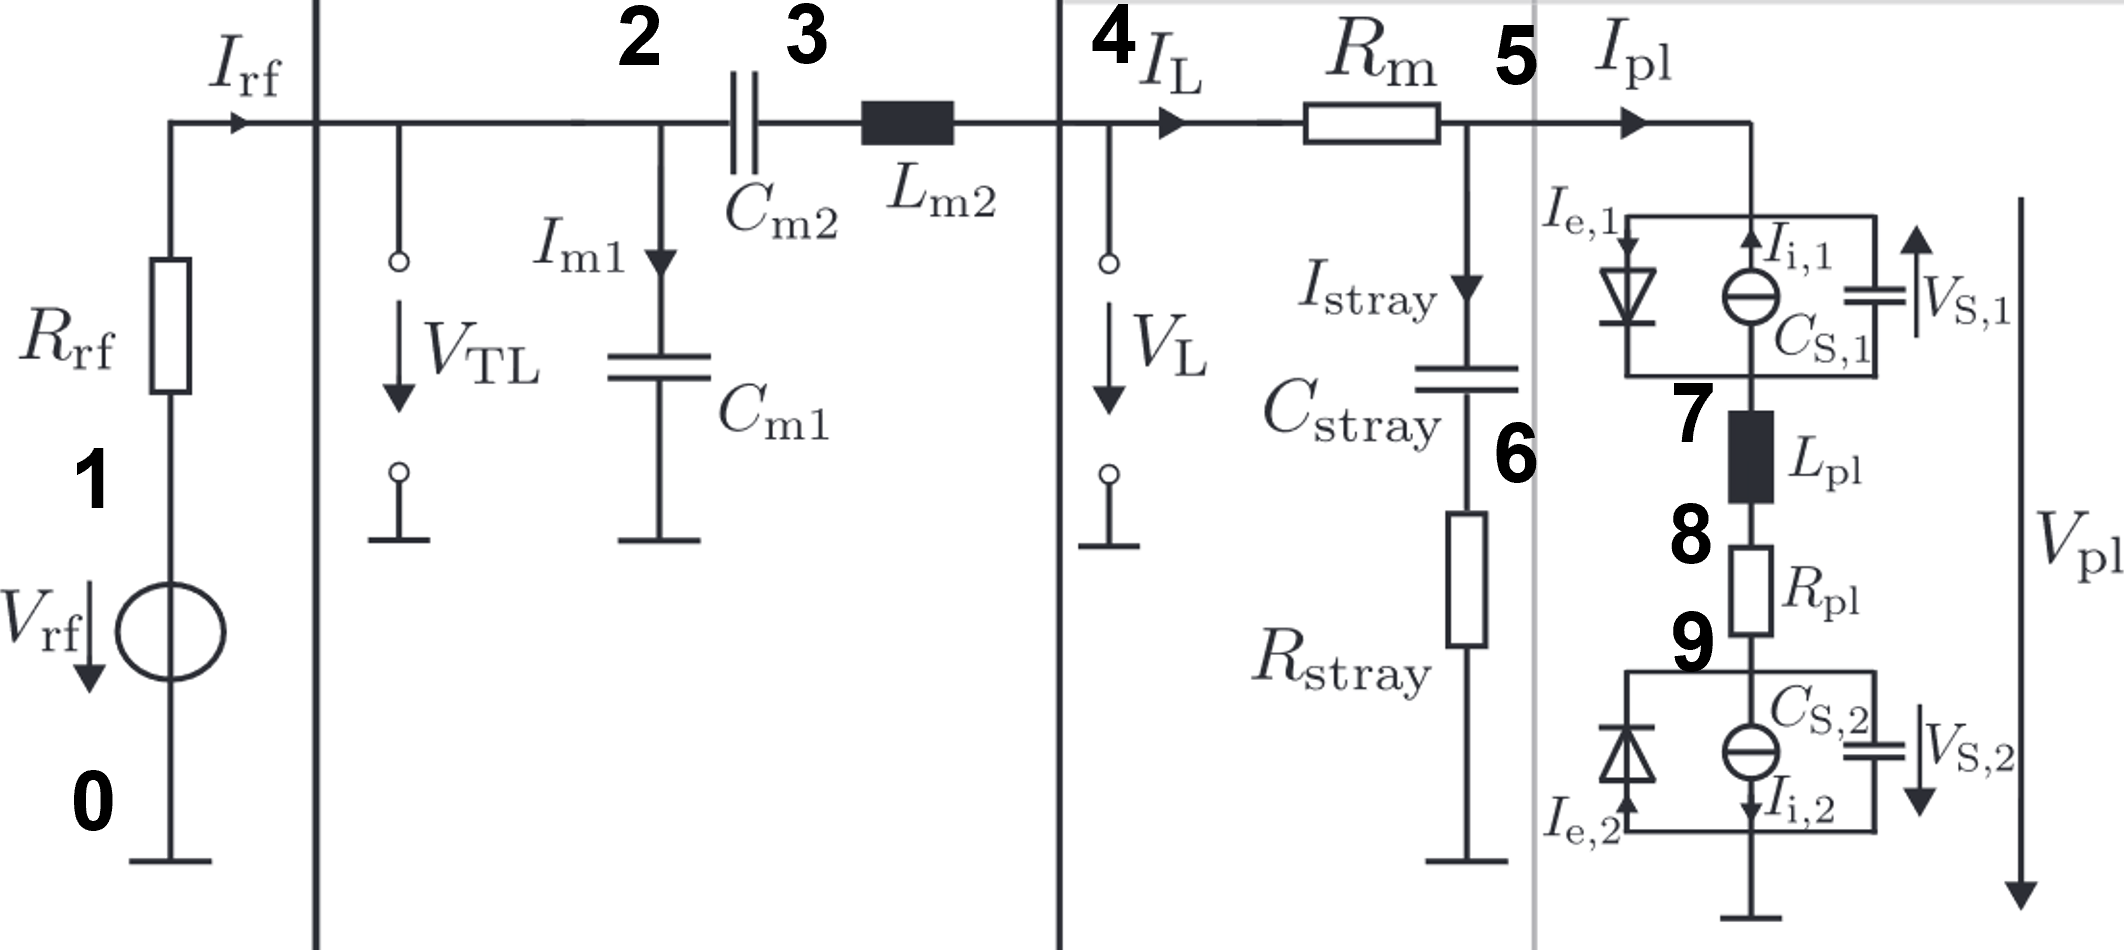

In [11]:
##########
# 8. Определяем и считаем цепь
##########

val_R_rf = 50
val_C_m1 = 1550e-12
val_C_m2 = 175e-12
val_L_m2 = 1500e-9
val_R_m = 0.5
val_C_stray = 200e-12
val_R_stray = 0.5

def calcCircuit(a_Te, a_ne):
    
    #################
    # 7. Вычисляемые величины №2
    #################

    Km = Kel(a_Te) + Kiz(a_Te) + Kex(a_Te)          # Коэффициент электронно-нейтральных столкновений [м^3*с^-1]
    nu_el_netr = Km*ng                              # Частота электронно-нейтральных столкновений [c^-1]
    v_midd_e = math.sqrt(8*qe*a_Te/(math.pi*me))    # Средняя тепловая скорость электронов
    nu_eff = nu_el_netr+(v_midd_e/l_B)              # Эффективная частота электронно-нейтральных столкновений [c^-1]
    Lp = l_B*me/(qe**2*a_ne*Ae)                     # Индуктивность bulk плазмы [Гн]
    Rp = nu_eff*Lp                                  # Сопротивление bulk плазмы [Ом]
    alpha = -1/a_Te                                 # Коэффициент показателя экспоненты электронного тока
    Iion1 = qe*a_ne*u_Bohm(a_Te)*Ae                 # Полный ионный ток на управляющий электрод [А]
    Iion2 = qe*a_ne*u_Bohm(a_Te)*Ag                 # Полный ионный ток на заземленный электрод [А]
    Ie01 = qe*a_ne*v_midd_e*Ae                      # Амплитуда электронного тока у управляющего электрода [А]
    Ie02 = qe*a_ne*v_midd_e*Ag                      # Амплитуда электронного тока у заземленного электрода [А]
    CCs1 = (qe*a_ne*eps_0*Ae**2)/2                  # Коэффициент при емкости слоя управляющего электрода
    CCs2 = (qe*a_ne*eps_0*Ag**2)/2                  # Коэффициент при емкости слоя заземленного электрода
    
    print(f'Lp={Lp:.10f} [H] Rp={Rp:.3f} [ohm] CCs1={CCs1} CCs2={CCs2}')

    circuit = Circuit('RF discharge impedance')
    circuit.SinusoidalVoltageSource('V0', 1, 0, amplitude = Vm, frequency = f0) # Фаза результатов сдвинута относительно [Schmidt], т.к. там cos, а тут sin
    circuit.R('Rrf', 1, 2, val_R_rf)
    circuit.C('Cm1', 2, 0, val_C_m1)
    circuit.C('Cm2', 2, 3, val_C_m2)
    circuit.L('Lm2', 3, 4, val_L_m2)
    circuit.R('Rm', 4, 5, val_R_m)
    circuit.C('Cstray', 5, 6, val_C_stray)
    circuit.R('Rstray', 6, 0, val_R_stray)
    circuit.BehavioralSource('Be_e', 5, 7, current_expression=f'v(7,5) > 0 ? {Ie01}*exp({alpha}*v(7,5)) : 1e-12')
    circuit.CurrentSource('Bi_e', 7, 5, Iion1)
    circuit.BehavioralCapacitor('Cs1', 7, 5, capacitance_expression=f'C=\'sqrt({CCs1}/abs(v(7,5)))\'')
    circuit.L('L_p', 7, 8, Lp)
    circuit.R('R_p', 8, 9, Rp)
    circuit.BehavioralSource('Be_g', 10, 9, current_expression=f'v(9,10) > 0 ? {Ie02}*exp({alpha}*v(9,10)) : 1e-12')
    circuit.CurrentSource('Bi_g', 9, 10, Iion2)
    circuit.BehavioralCapacitor('Cs2', 9, 10, capacitance_expression=f'C=\'sqrt({CCs2}/abs(v(9,10)))\'')
    circuit.VoltageSource('Viz', 10, 0, 0)
    
    simulator = circuit.simulator()
    simulator._initial_condition={'v(5)':1e-10, 'v(9)':1e-10} # Надо задать какие-то (около но ненулевые ННУ,
                                                              # т.к. иначе pyspice ломается на предупреждениях от Ngspice
    #print(simulator) # Можно напечатать .IC для проверки
    return (simulator.transient(step_time=Tf/100, end_time=tmax_sim), Rp)

ne_new = 0
iter_no = 0
#ne = 1.25e+15

while np.abs(ne - ne_new) > eps_ne:
    
    if iter_no > 0:
        ne = ne_new

    iter_no = iter_no + 1
    
    print(f'ne iteration #{iter_no: =2}:', end=' ')

    (analysis, out_Rp) = calcCircuit(Te, ne)

    time_raw = np.array(analysis.time)
    Vpl_raw = getU('5', '0', analysis)           # Vpl
    Ipl_raw = getU('8', '9', analysis)/out_Rp    # Ipl
    Vs1_raw = getU('5', '7', analysis)           # Vs1
    Vs2_raw = getU('9', '10', analysis)          # Vs2

    num_perods_for_integration = 50  # Определить минимально необходимое количество периодов на просчитывать, при котором результат интеграла сходится.
                                     # Это и будет критерий наступления установившегося режима

    t_integration = extract_N_periods(time_raw, 1, num_perods_for_integration, 'rev')

    Vpl_integration = extract_N_periods(Vpl_raw, 1, num_perods_for_integration, 'rev')
    Ipl_integration = extract_N_periods(Ipl_raw, 1, num_perods_for_integration, 'rev')
    Ppl_integration = np.multiply(Vpl_integration, Ipl_integration)

    Ppl = get_mean(t_integration, Ppl_integration, num_perods_for_integration) 
    print(f'Ppl={Ppl:.3e} [W]', end=' ')
    
    Vs1_integration = extract_N_periods(Vs1_raw, 1, num_perods_for_integration, 'rev')
    Vs2_integration = extract_N_periods(Vs2_raw, 1, num_perods_for_integration, 'rev')

    _Vs1 = get_mean(t_integration, Vs1_integration, num_perods_for_integration)
    _Vs2 = get_mean(t_integration, Vs2_integration, num_perods_for_integration)
    
    ##############
    # Определение ne
    ##############

    Pguess = ne*Vp*ng*Kiz(Te)*(eps_c(Te) + eps_e + fE*np.abs(_Vs1) + fG*np.abs(_Vs2) + Te/2)*qe
    print(f'Pguess={Pguess:.3e} [W]', end=' ')

    ne_new = Ppl/(Vp*ng*Kiz(Te)*(eps_c(Te) + eps_e + fE*np.abs(_Vs1) + fG*np.abs(_Vs2) + Te/2)*qe)
    print(f'ne={ne:.3e} [cm^-3]', end=' ')
    print(f'ne_new={ne_new:.3e} [cm^-3]', end=' ')

    if np.abs(ne_new - ne) < eps_ne:
        print(f'|ne_new - ne|={np.abs(ne_new - ne):.3e} <- CONVERGED')
    else:
        print(f'|ne_new - ne|={np.abs(ne_new - ne):.3e}')

#print(circuit) # Можно напечатать получившийся netlist для проверки

ne iteration # 1: Lp=0.0000001692 [H] Rp=10.135 [ohm] CCs1=8.48951202427262e-20 CCs2=7.640560821845356e-19
Ppl=3.924e+00 [W] Pguess=3.935e+00 [W] ne=1.199e+15 [cm^-3] ne_new=1.196e+15 [cm^-3] |ne_new - ne|=3.423e+12 <- CONVERGED


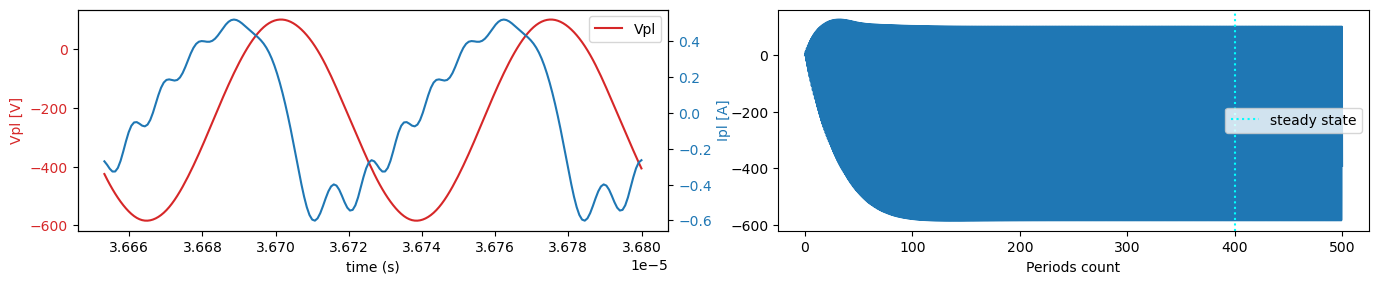

In [12]:
# Извлекаем интересующие токи и напряжения

time_raw = np.array(analysis.time)

Vpl_raw = getU('5', '0', analysis)           # Vpl
Ipl_raw = getU('8', '9', analysis)/out_Rp    # Ipl
V_R_rf_raw = getU('2', '1', analysis)        # Vrf
Irf_raw = V_R_rf_raw/val_R_rf                # Irf
Vl_raw = getU('2', '0', analysis)            # Vl
Vs1_raw = getU('5', '7', analysis)           # Vs1
Vs2_raw = getU('9', '10', analysis)          # Vs2
V_R_rf_raw = getU('2', '1', analysis)        # Vrf
VRm_raw = getU('4', '5', analysis)           # VRm
VRstray_raw = getU('6', '0', analysis)       # VRm

# Строим ток и напряжение на плазме (2 периода)

first_steady_period = 400   # Номер периода, с которого считаем, что установившийся режим наступил

time_2_last_periods = extract_N_periods(time_raw, 1, 2, 'rev')
Vpl_2_last_periods = extract_N_periods(Vpl_raw, 1, 2, 'rev')
Ipl_2_last_periods = extract_N_periods(Ipl_raw, 1, 2, 'rev')

fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(14, 3))

ax1[0].set_xlabel('time (s)')
ax1[0].set_ylabel('Vpl [V]', color='tab:red')
ax1[0].plot(time_2_last_periods, Vpl_2_last_periods, color='tab:red', label='Vpl')  # Показываем два _предпоследних_ периода, т.к.
ax1[0].tick_params(axis='y', labelcolor='tab:red')
ax2 = ax1[0].twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Ipl [A]', color='tab:blue')  # we already handled the x-label with ax1
ax2.plot(time_2_last_periods, Ipl_2_last_periods, color='tab:blue', label='Ipl')
ax2.tick_params(axis='y', labelcolor='tab:blue')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1[0].legend()
ax1[1].plot(time_raw/Tf, Vpl_raw)  # Обзорный график для определения установившегося режима
ax1[1].axvline(first_steady_period, color='cyan', linestyle=':', label='steady state')
ax1[1].legend()
_=ax1[1].set_xlabel('Periods count')

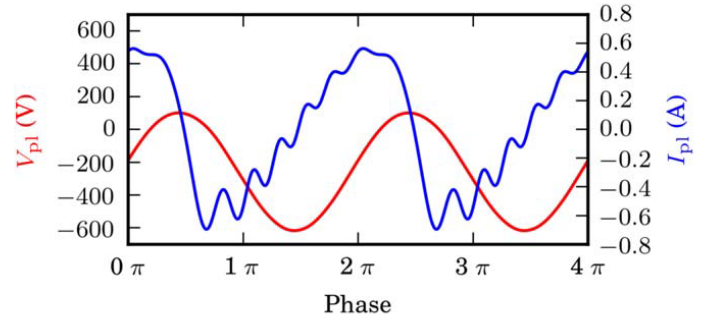

In [14]:
a = np.diff(time_raw)
np.set_printoptions(threshold=100)
print(a)

[7.37463127e-12 6.19508119e-13 1.23901624e-12 ... 7.37463127e-10
 7.37463127e-10 1.77668563e-10]


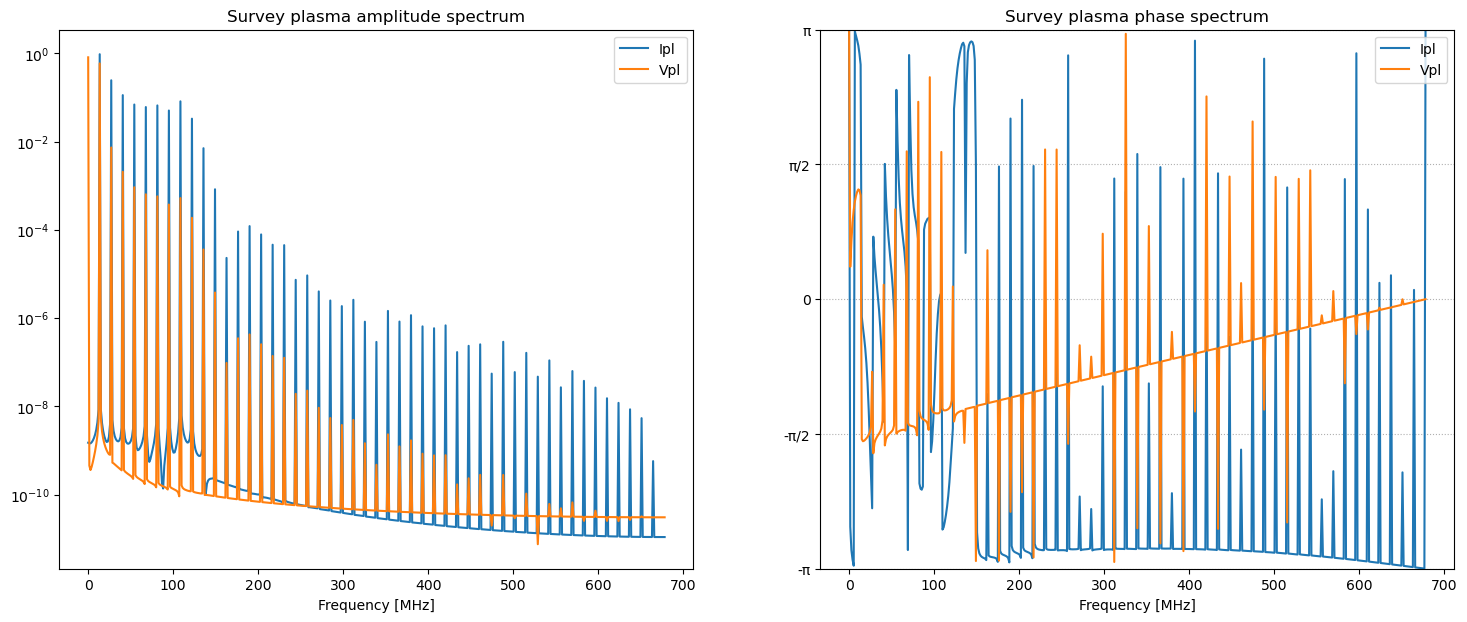

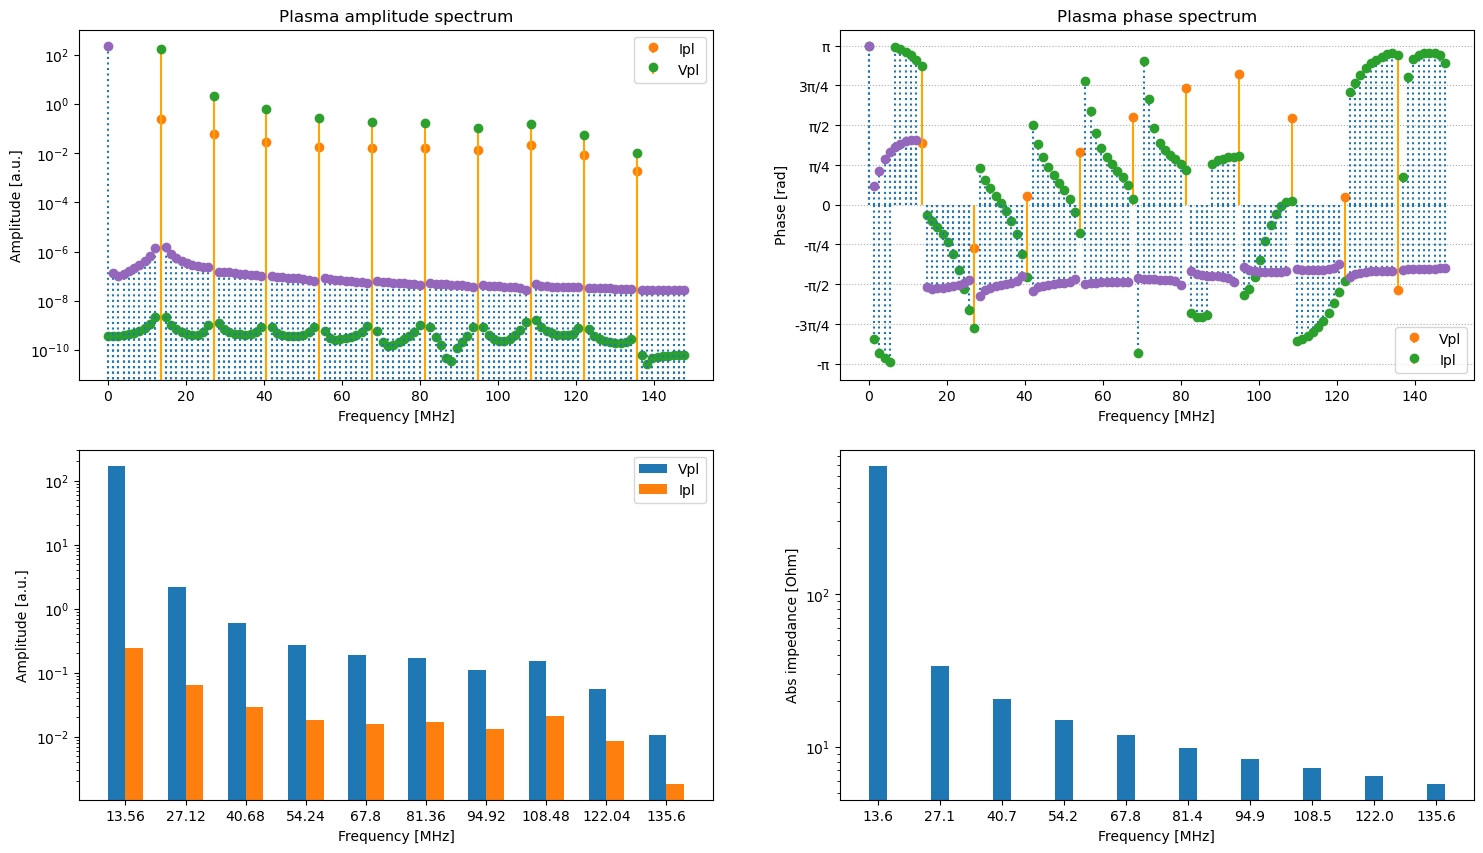

In [19]:
# Спектры

(_, Ipl_abs, Ipl_phase, freqs, freqsMHz, reduced_freqs, Ipl_reduced_abs, Ipl_reduced_angle, waste_freqs, Ipl_waste_abs, Ipl_waste_angle, true_freqs, Ipl_true_abs, Ipl_true_angle) = get_spectra(Ipl_raw)
(_, Vpl_abs, Vpl_phase, _, _, _, Vpl_reduced_abs, Vpl_reduced_angle, _, Vpl_waste_abs, Vpl_waste_angle, _, Vpl_true_abs, Vpl_true_angle) = get_spectra(Vpl_raw)

(_, _, _, _, _, _, _, _, _, _, _, _, Il_true_abs, Il_true_angle) = get_spectra(Irf_raw)
(_, _, _, _, _, _, _, _, _, _, _, _, Vl_true_abs, Vl_true_angle) = get_spectra(Vl_raw)

# Обзорные спектры

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

Ipl_norm = np.linalg.norm(Ipl_abs)
Vpl_norm = np.linalg.norm(Vpl_abs)
Zpl_norm = Vpl_norm/Ipl_norm

Ipl_normalized = Ipl_abs/Ipl_norm
Vpl_normalized = Vpl_abs/Vpl_norm

axs[0].semilogy(freqsMHz, Ipl_normalized, label='Ipl')
axs[0].semilogy(freqsMHz, Vpl_normalized, label='Vpl')
axs[0].set_xlabel('Frequency [MHz]')
axs[0].set_title('Survey plasma amplitude spectrum')
axs[0].legend()
axs[1].plot(freqsMHz, Ipl_phase, label='Ipl')
axs[1].plot(freqsMHz, Vpl_phase, label='Vpl')
axs[1].set_xlabel('Frequency [MHz]')
axs[1].set_title('Survey plasma phase spectrum')
axs[1].set_ylim(bottom=-np.pi, top=np.pi)
axs[1].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], ['-π', '-π/2', '0', 'π/2', 'π'])
axs[1].grid(axis='y', linestyle=':')
axs[1].legend()

# Укрупненные спектры (первые nHarm гармоник)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

axs[0,0].stem(true_freqs, Ipl_true_abs, linefmt='orange', markerfmt='C1o', label='Ipl', basefmt=' ')
axs[0,0].stem(true_freqs, Vpl_true_abs, linefmt='orange', markerfmt='C2o', label='Vpl', basefmt=' ')
axs[0,0].stem(waste_freqs, Ipl_waste_abs, linefmt=':', basefmt=' ')
axs[0,0].stem(waste_freqs, Vpl_waste_abs, linefmt=':', basefmt=' ')
axs[0,0].set_yscale('log')
axs[0,0].set_xlabel('Frequency [MHz]')
axs[0,0].set_ylabel('Amplitude [a.u.]')
axs[0,0].set_title('Plasma amplitude spectrum')
axs[0,0].legend()
axs[0,1].stem(true_freqs, Vpl_true_angle, linefmt='orange', markerfmt='C1o', label='Vpl', basefmt=' ')
axs[0,1].stem(true_freqs, Ipl_true_angle, linefmt='orange', markerfmt='C2o', label='Ipl', basefmt=' ')
axs[0,1].stem(waste_freqs, Ipl_waste_angle, linefmt=':', basefmt=' ')
axs[0,1].stem(waste_freqs, Vpl_waste_angle, linefmt=':', basefmt=' ')
axs[0,1].set_ylabel('Phase [rad]')
axs[0,1].set_xlabel('Frequency [MHz]')
axs[0,1].set_title('Plasma phase spectrum')
axs[0,1].set_ylim(bottom=-1.1*np.pi, top=1.1*np.pi)
axs[0,1].set_yticks([-np.pi, -3*np.pi/4, -np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi], ['-π', '-3π/4', '-π/2', '-π/4', '0', 'π/4', 'π/2', '3π/4', 'π'])
axs[0,1].grid(axis='y', linestyle=':')
axs[0,1].legend()

barWidth = 4
br2 = [x + barWidth for x in true_freqs]       
axs[1,0].bar(true_freqs, Vpl_true_abs, width = barWidth, label='Vpl')
axs[1,0].bar(br2, Ipl_true_abs, width = barWidth, label='Ipl')
axs[1,0].set_yscale('log')
axs[1,0].set_ylabel('Amplitude [a.u.]')
axs[1,0].set_xlabel('Frequency [MHz]')
axs[1,0].legend()
_ = axs[1,0].set_xticks([x + 0.5*barWidth for x in true_freqs], np.round(true_freqs, 2))
axs[1,1].bar(true_freqs, Vpl_true_abs/Ipl_true_abs, width = barWidth)
_ = axs[1,1].set_xticks(np.round(true_freqs, 2))
axs[1,1].set_yscale('log')
axs[1,1].set_ylabel('Abs impedance [Ohm]')
_ = axs[1,1].set_xlabel('Frequency [MHz]')

In [16]:
print(f'Plasma impedance')
for i in range(true_freqs.size):
    print(f'{true_freqs[i]:.2f} MHz: V={Vpl_true_abs[i]:.3f} I={Ipl_true_abs[i]:.3f} Z={Vpl_true_abs[i]/Ipl_true_abs[i]:.3f} phi={np.degrees(Vpl_true_angle[i]-Ipl_true_angle[i]):.3f} Zpl=({Vpl_true_abs[i]/Ipl_true_abs[i]*np.cos(Vpl_true_angle[i]-Ipl_true_angle[i]):.3f} j{Vpl_true_abs[i]/Ipl_true_abs[i]*np.sin(Vpl_true_angle[i]-Ipl_true_angle[i]):.3f})')
    print(f'           Zl=({Vl_true_abs[i]/Il_true_abs[i]*np.cos(Vl_true_angle[i]-Il_true_angle[i]):.3f} j{Vl_true_abs[i]/Il_true_abs[i]*np.sin(Vl_true_angle[i]-Il_true_angle[i]):.3f})')

Plasma impedance
13.56 MHz: V=172.110 I=0.247 Z=696.985 phi=-87.334 Zpl=(32.421 j-696.230)
           Zl=(-31.427 j-17.310)
27.12 MHz: V=2.145 I=0.063 Z=33.843 phi=91.161 Zpl=(-0.685 j33.836)
           Zl=(50.000 j-0.000)
40.68 MHz: V=0.603 I=0.029 Z=20.629 phi=91.558 Zpl=(-0.561 j20.621)
           Zl=(50.000 j-0.000)
54.24 MHz: V=0.269 I=0.018 Z=15.046 phi=92.024 Zpl=(-0.531 j15.036)
           Zl=(50.000 j-0.000)
67.80 MHz: V=0.186 I=0.016 Z=11.871 phi=92.507 Zpl=(-0.519 j11.859)
           Zl=(50.000 j0.000)
81.36 MHz: V=0.167 I=0.017 Z=9.802 phi=93.000 Zpl=(-0.513 j9.788)
           Zl=(50.000 j0.000)
94.92 MHz: V=0.109 I=0.013 Z=8.340 phi=93.502 Zpl=(-0.509 j8.324)
           Zl=(50.000 j0.000)
108.48 MHz: V=0.153 I=0.021 Z=7.248 phi=94.011 Zpl=(-0.507 j7.230)
           Zl=(50.000 j0.000)
122.04 MHz: V=0.055 I=0.009 Z=6.400 phi=94.530 Zpl=(-0.505 j6.380)
           Zl=(50.000 j-0.000)
135.60 MHz: V=0.010 I=0.002 Z=5.721 phi=-264.942 Zpl=(-0.504 j5.699)
           Zl=(50.000 j0.

In [17]:
VRm_raw = getU('4', '5', analysis)          # VRm
VRstray_raw = getU('6', '0', analysis)      # VRm

VRm_integration = extract_N_periods(VRm_raw, 1, num_perods_for_integration, 'rev')
P_R_m = get_mean(t_integration, np.multiply(VRm_integration, VRm_integration), num_perods_for_integration)/val_R_m

VRstray_integration = extract_N_periods(VRstray_raw, 1, num_perods_for_integration, 'rev')
P_R_stray = get_mean(t_integration, np.multiply(VRstray_integration, VRstray_integration), num_perods_for_integration)/val_R_stray

Ppl = 3.9235392195603644 [W]
_Vs1 = -298.7159740241317 [V]
_Vs2 = 61.94783823499264 [V]
PRrf = 36.07499671843572 [W]
PRm = 10.111887685878587 [W]
PRstray = 8.61123394086492 [W]


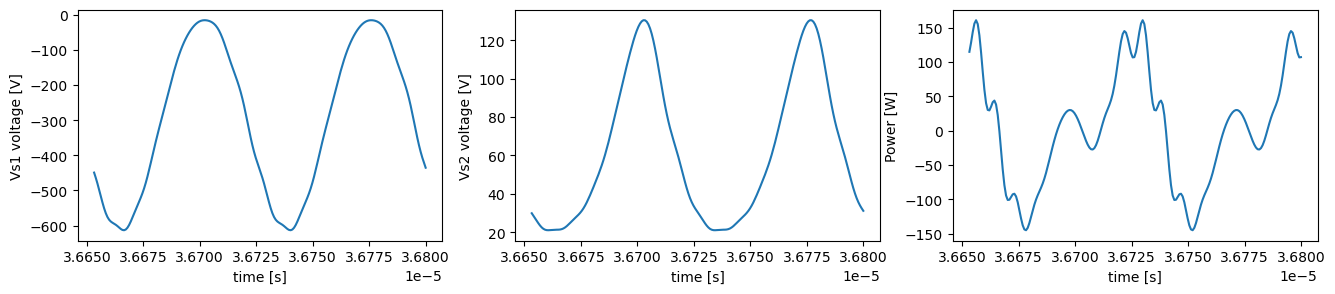

In [18]:
#power_norm = v_norm/i_norm
#print(power_norm)

num_perods_for_integration = 50  # Определить минимально необходимое количество периодов на просчитывать, при котором результат интеграла сходится.
                                 # Это и будет критерий наступления установившегося режима

t_integration = extract_N_periods(time_raw, 1, num_perods_for_integration, 'rev') #data[-(num_perods_for_integration+1)*sim_periods_div:-1*sim_periods_div]

Vpl_integration = extract_N_periods(Vpl_raw, 1, num_perods_for_integration, 'rev')
Ipl_integration = extract_N_periods(Ipl_raw, 1, num_perods_for_integration, 'rev')
Ppl_integration = np.multiply(Vpl_integration, Ipl_integration)

Ppl = get_mean(t_integration, Ppl_integration, num_perods_for_integration) 

print(f'Ppl = {Ppl} [W]')

Vs1_integration = extract_N_periods(Vs1_raw, 1, num_perods_for_integration, 'rev')
Vs2_integration = extract_N_periods(Vs2_raw, 1, num_perods_for_integration, 'rev')

V_r_rf_integration = extract_N_periods(V_R_rf_raw, 1, num_perods_for_integration, 'rev')
P_R_rf = get_mean(t_integration, np.multiply(V_r_rf_integration, V_r_rf_integration), num_perods_for_integration)/val_R_rf

_Vs1 = get_mean(t_integration, Vs1_integration, num_perods_for_integration)
_Vs2 = get_mean(t_integration, Vs2_integration, num_perods_for_integration)

print(f'_Vs1 = {_Vs1} [V]')
print(f'_Vs2 = {_Vs2} [V]')

print(f'PRrf = {P_R_rf} [W]')
print(f'PRm = {P_R_m} [W]')
print(f'PRstray = {P_R_stray} [W]')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 3))

axs[0].plot(time_2_last_periods, extract_N_periods(Vs1_raw, 1, 2, 'rev'))
axs[0].set_ylabel('Vs1 voltage [V]')
axs[0].set_xlabel('time [s]')

axs[1].plot(time_2_last_periods, extract_N_periods(Vs2_raw, 1, 2, 'rev'))
axs[1].set_ylabel('Vs2 voltage [V]')
axs[1].set_xlabel('time [s]')

axs[2].plot(time_2_last_periods, extract_N_periods(Ppl_integration, 1, 2, 'rev')) # Надо сместить на 1 период!
axs[2].set_ylabel('Power [W]')
_=axs[2].set_xlabel('time [s]')


In [49]:
print(Rp)

NameError: name 'Rp' is not defined